In [1]:
# code for loading the format for the notebook
import os

# path : store the current path to convert back to it later
path = os.getcwd()
os.chdir( os.path.join('..', 'notebook_format') )
from formats import load_style
load_style()

In [2]:
os.chdir(path)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# change default figure and font size
plt.rcParams['figure.figsize'] = 8, 6 
plt.rcParams['font.size'] = 12

# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
%matplotlib inline
%load_ext watermark
%load_ext autoreload 
%autoreload 2

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,matplotlib

Ethen 2016-12-28 10:17:24 

CPython 3.5.2
IPython 4.2.0

numpy 1.11.3
pandas 0.18.1
matplotlib 1.5.1


# Genetic Algorithm

**Genetic Algorithm (GA)** is a class of algorithms that is used for optimization. They find better answers to a "defined" question.

The intuition for **GA** is that they generate a bunch of "answer candidates" and use some sort of feedback to figure out how close the candidate is to the "optimal" solution. During the process, far-from-optimal candidates gets dropped and are never seen again, while close-to-optimal candidates are combined with each other and maybe mutate slightly to see if they can get closer to optimal. The mutation is an attempt to modify the candidates from time to time to prevent the solution from getting stuck at the local optima.


## Chromosome

The "answer candidates" mentioned above are called **chromosomes**, which is the representation of a solution candidate.

**Chromosomes** mate and mutate to produce offspring. They either die due to survival of the fittest, or are allowed to produce offspring who may have more desirable traits and adhere to natural selection.

Suppose We're trying to optimize a very simple problem: trying to create a list of `N` integer numbers that equal `X` when summed together. If we set `N = 5` and `X = 200`, then our **chromosomes** will simply be a list (an array) with length of 5. Here is one possible **chromosome** that could be a solution candidate for our problem:

In [3]:
chromo_size = 5
low  = 0 # we want our solution to be bounded between 0 to 100 (inclusive)
high = 100

np.random.randint(low, high + 1, chromo_size)

array([26, 49, 19, 34, 77])

## Population

The collection of chromosomes is referred to as our **population**. When you run a GA, you don't just look at one chromosome at a time. You might have a **population** of 20 or 100 or 5,000 chromosomes going all at once.

In [4]:
pop_size = 6

pop = np.random.randint( low, high + 1, (pop_size, chromo_size) )
pop

array([[ 33, 100,  83,   3,  94],
       [ 79,  68,   3,  45,  33],
       [  3,  48,  11,  82,   9],
       [ 97,   4,  26,  43,  77],
       [ 26,  86,  29,  60,  95],
       [ 73,  41,  35,  78,  96]])

## Cost Function

But given all those randomly generated chromosomes, how do we measure the optimality of a chromosome and find the "correct" (or globally-optimum) chromosome?

The **cost function** (or error function, or fitness function as the inverse) is some sort of measure of the optimality of a chromosome. If we're calling it "fitness function" then we're shooting for higher scores, and if we're using "cost function" then we're looking for low scores.

In this case, we might define a **cost function** to be the absolute difference between the sum of the and the target number `X`. The reason we're using the square of the difference is so that we never end up with a negative cost, you can choose to square it if you want to.

In this case, since this problem is easy and contrived, we know that we're shooting for a cost of 0 (our sum of the numbers in the chromosome equals exactly to our target number) and that we can stop there. Sometimes that's not the case. Sometimes you're just looking for the lowest cost you can find, and need to figure out different ways to end the calculation. Other times you're looking for the highest fitness score you can find, and similarly need to figure out some other criteria to use to stop the calculation.

Using that rule as a cost function, we can calculate the costs of our population (each collection of chromosomes).

In [5]:
# determine the cost of an chromosome. lower is better
target = 200
cost = np.abs( np.sum(pop, axis = 1) - target )

# combine the cost and chromosome into one list
graded = [ ( c, list(p) ) for p, c in zip(pop, cost) ]
for cost, chromo in graded:
    print( "chromo {}'s cost is {}".format( chromo, cost ) )

chromo [33, 100, 83, 3, 94]'s cost is 113
chromo [79, 68, 3, 45, 33]'s cost is 28
chromo [3, 48, 11, 82, 9]'s cost is 47
chromo [97, 4, 26, 43, 77]'s cost is 47
chromo [26, 86, 29, 60, 95]'s cost is 96
chromo [73, 41, 35, 78, 96]'s cost is 123


In [6]:
# side note, we're converting the array to a list in `list(p)` since
# if the cost for two chromosomes are the same, then the sorting will break
# when the second element is an array
"""
test1 = ( 30, np.array(( 1, 2, 4 )) )
test2 = ( 30, np.array(( 3, 4, 5 )) )
sorted([test1, test2])
"""
print('code above will break')

code above will break


## Evolution - Crossover

Just like in evolution, you might be inclined to have the best and strongest chromosomes of the population mate with each other (The technical term for mating is **crossover**), with the hope that their offspring will be even healthier than either parent.

For each generation we'll retain a portion of the best performing chromosomes as judged by our cost/fitness function (the portion is a parameter that you can tune). These high-performers will be the parents of the next **generation**, or more intuitely, the next iteration.

Mating these parents is also very simple. You randomly pick two chromosomes, a male and a female (just a metaphor), and pick a point in the middle. This point can be dead-center if you want, or randomized if you prefer. Take that middle point (called a "pivot" point), and make two new chromosomes by combining the first half of one with the second half of the other and vice versa (It's usually recommended to use even numbers as your population size).

By repeating the mating step, we repopulate the population to its desired size for the next **generation**. e.g. if you take the top 30 chromosomes in a population of 100, then you'd need to create 100 new chromosomes by mating them.

## Evolution - Mutation

**Crossover** is the main step of how you get from one generation of chromosomes to the next, but it alone has a problem: If all you do is mate your candidates to go from generation to generation, you'll have a chance of getting stuck near a "local optimum, an answer that's pretty good but not necessarily the "global optimum" (the best you can hope for).

A GA would achieve very little if not for the combined effects of both **crossover** and **mutation**. **Crossover** helps discover more optimal solutions from already-good solutions, but it's the **mutation** that pushes the search for solutions in new directions.

**Mutation** is a completely random process by which you target an unsuspecting chromosome and blast it with just enough radiation to make one of its elements randomly change. How and when you mutate is up to you. e.g. If you choose a **mutation rate** of 0.1 (again any rate you want). Then if you randomly generated a number from 0 to 1 and if it happens to be below 0.1, the chromosome will **mutate**. 

As for the **mutation**, it can be randomly picking a element of the chromosome and add the number by 5, dividing the number by 2 or change it to a randomly generated number. Do whatever you want with it as long as it's relevant to the context of the problem. Like in the beginning of our problem, we set a maximum and minimum boundary when generating our initial values for each of the chromosome `min = 0 max = 100`. Then for our **mutation**, we can restrict our mutated number to be within this boundary (not really necessary here, but more problems that have indispensible boundaries this is crucial). And if we cross that border we can simply set it back to the value of that border (e.g. the mutated number is 102, we can simply squeeze it back to 100, our upper bound).

## Recap

The basic building blocks (parameters) of GA consists of: 

- **Chromosomes**. Representations of candidate solutions to your problem. They consist of the representation itself (in our case, a N element list)
- **Population**. A group of chromosomes. The population will remain the same size (you get to choose your population size.), but will typically evolve to better cost/fitness scores over time.
- **Cost/Fitness Function**. Used to evaluate your answer.
- The ability to **Crossover** and **Mutate**.
- The population experiences mutiple **generations** (iterations, this is a user-specified parameter).

And a typical GA takes the form of:

1. Initialize a population. Just fill it with completely random chromosomes that does not step over the boundary, if there is one.
2. Calculate the cost/fitness score for each chromosomes.
3. Sort the chromosomes by the user-defined cost/fitness score.
4. Retain a certain number of the parent chromosomes, where you get to pick the number of chromosome that will retain.
5. Mate the retained parent chromosomes to generate the children chromosomes. You can decide how you want to mate them. This process will keep going until the number of children chromosome is the same as the number of the original parent chromosome. 
6. Mutate the children chromosomes at random. Again, you can decide how to do this (resticted to the boundary).
7. Compare the parent chromosomes and the children chromosomes and choose the best ones (e.g. you have 100 parent chromosomes and generated 100 children chromosomes, you compare 200 chromosomes and retain the best 100 chromosomes). In other words, we're killing the poorly performed children.
8. If the algorithm has not met some kind of completion criteria, return to step 2 with the new chromosomes. The completion criteria for this example is pretty simple: stop when you get a cost of 0. But this isn't always the case. Sometimes you don't know the minimum achievable cost. Or, if you're using fitness instead of cost, you may not know the maximum possible fitness. In those cases you can stop the algorithm if the best score hasn't changed in 100 generations (iterations), or any other number depending on how much time are you willing to wait or the computation resources that you have, and use that as your answer.

---

Putting it all together, the code might look something like [this](https://github.com/ethen8181/machine-learning/blob/master/ga/ga.py) (code on github).

In [7]:
from ga import GA

In [8]:
# calls the Genetic Algorithm
ga1 = GA( 
    generation = 10, 
    pop_size = 50, 
    chromo_size = 5, 
    low = 0, 
    high = 100, 
    retain_rate = 0.5, 
    mutate_rate = 0.2
)
ga1.fit(target = 200)

In [9]:
# the best chromo and its cost during each generation (iteration)
ga1.generation_history

[info(cost=0, chromo=[29, 63, 50, 24, 34]),
 info(cost=0, chromo=[29, 63, 50, 24, 34]),
 info(cost=0, chromo=[29, 63, 50, 24, 34]),
 info(cost=0, chromo=[29, 63, 50, 24, 34]),
 info(cost=0, chromo=[29, 63, 50, 24, 34]),
 info(cost=0, chromo=[29, 63, 50, 24, 34]),
 info(cost=0, chromo=[29, 63, 50, 24, 34]),
 info(cost=0, chromo=[29, 63, 50, 24, 34]),
 info(cost=0, chromo=[29, 63, 50, 24, 34]),
 info(cost=0, chromo=[29, 63, 50, 24, 34])]

In [10]:
# the overall best
ga1.best

info(cost=0, chromo=[29, 63, 50, 24, 34])

Even though we defined our generation number to be 10, we can reach our goal for only a small iteration count. Thus for problems where you don't the optimal answer, it's best to define a stopping criteria, instead of letting it run wild.

## Supplement

Recall that in the beginning, we said that Genetic Algorithm (GA) is a class of algorithms that is used for optimization. The term "is a class of algorithms" means that there're many different variations of GA. For example, in the evolution stage, instead of retaining a portion of the best performing chromosomes as judged by our cost/fitness function liked we mentioned above, we can throw darts to decide who gets to stay. 

By thowing darts, we are simply saying that we have some probability to select some of the lesser performing chromosomes in the current generation to be considered for the evolution stage. This *MIGHT* decrease our likelihood of getting stuck in the local optima. Example below:

In [11]:
"""
we have our chromosome and cost, the sum of the cost will be 
the probability's denominator, while the probability's numerator
is each chromo's cost (NOTE THAT THIS FOR MAXIMIZATION PROBLEM)
"""
denominator = 0
for cost, chromo in graded:
    denominator += cost

# the chromo, the cost and its probability of getting chosen as the
# parent used for evolution
for cost, chromo in graded:
    prob = cost / denominator
    print( "chromo {}'s cost is {} and it has a {} prob".format( chromo, cost, prob ) )

chromo [33, 100, 83, 3, 94]'s cost is 113 and it has a 0.2488986784140969 prob
chromo [79, 68, 3, 45, 33]'s cost is 28 and it has a 0.06167400881057269 prob
chromo [3, 48, 11, 82, 9]'s cost is 47 and it has a 0.10352422907488987 prob
chromo [97, 4, 26, 43, 77]'s cost is 47 and it has a 0.10352422907488987 prob
chromo [26, 86, 29, 60, 95]'s cost is 96 and it has a 0.21145374449339208 prob
chromo [73, 41, 35, 78, 96]'s cost is 123 and it has a 0.2709251101321586 prob


As you can see, we're not restricted to choose only the "best" chromosomes to be considered for the evolution stage. Each chromosome has a chance of being chosen, but we of course, are still in favor of the chromosomes that are performing well (has a higher probability of getting chosen).

In [12]:
"""
same idea for MINIMIZATION PROBLEM, except we have to 
use reciprocal costs, so that the lower the cost
the higher the probability
"""
denominator = 0
for cost, chromo in graded:
    denominator += 1 / cost

# the chromo, the cost and its probability of getting chosen as the
# parent used for evolution
for cost, chromo in graded:
    prob = ( 1 / cost ) / denominator
    print( "chromo {}'s cost is {} and it has a {} prob".format( chromo, cost, prob ) )

# you can confirm that the probability does add up to one if
# you're suspicious ^^

chromo [33, 100, 83, 3, 94]'s cost is 113 and it has a 0.08375204158471923 prob
chromo [79, 68, 3, 45, 33]'s cost is 28 and it has a 0.3379993106811883 prob
chromo [3, 48, 11, 82, 9]'s cost is 47 and it has a 0.2013612914696441 prob
chromo [97, 4, 26, 43, 77]'s cost is 47 and it has a 0.2013612914696441 prob
chromo [26, 86, 29, 60, 95]'s cost is 96 and it has a 0.09858313228201326 prob
chromo [73, 41, 35, 78, 96]'s cost is 123 and it has a 0.07694293251279084 prob


# Travel Salesman Problem (TSP)

We can also use the Genetic Algorithm on a slightly more complex problem, the travel salesman problem. The problem that we're trying to solve is given a set of cities and distance between every pair of cities, we wish to find the shortest possible route that visits every city exactly once and returns to the starting point. 

Please refer to the first section of this post - [Tutorial: Applying a Genetic Algorithm to the traveling salesman problem](http://www.theprojectspot.com/tutorial-post/applying-a-genetic-algorithm-to-the-travelling-salesman-problem/5) for a more comprehensive description of the problem definition and how to modify the Genetic Algorithm a bit so that it becomes suitable for the problem.

In [13]:
import random
from collections import namedtuple

In [14]:
# example dataset
file = 'TSP_berlin52.txt'
tsp_data = pd.read_table( file, skiprows = 1, header = None, 
                          names = ['city', 'x', 'y'], sep = ' ' )
print(tsp_data.shape)
tsp_data.head()

(52, 3)


,city,x,y
0,1,565.0,575.0
1,2,25.0,185.0
2,3,345.0,750.0
3,4,945.0,685.0
4,5,845.0,655.0


The Genetic Algorithm for the travel salesman problem is written as a module this time. [[link](https://github.com/ethen8181/machine-learning/blob/master/ga/tsp_solver)]

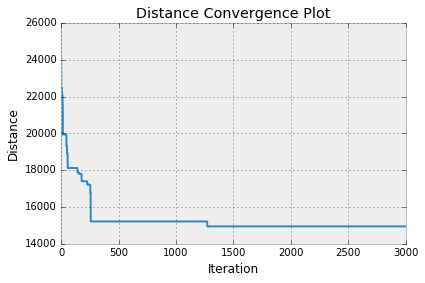

tour_info(dist=14946.450404336612, tour=array([20, 27, 14, 47, 26, 25, 37, 15,  5,  4, 43, 46, 24, 16, 50, 38, 39,
       32, 42,  7,  2, 17, 31, 22, 44, 35,  6, 40, 36, 49, 18, 19, 21, 23,
       30, 10,  9, 45,  8, 41,  3, 34,  1, 29, 28, 13, 52, 51, 12, 11, 33,
       48]))

In [15]:
from tsp_solver import TSPGA

tsp_ga = TSPGA(
    generation = 3000, 
    population_size = 250, 
    retain_rate = 0.4, 
    mutate_rate = 0.3
)
tsp_ga.fit(tsp_data)

# distance convergence plot, and the best tour's distance
# and the corresponding city tour
tsp_ga.convergence_plot()
tsp_ga.best_tour

A quick script for outputting the result.

```python

# output file name = algorithm name + the data's file name
output_filename = 'GA_' + file + '.txt'
best_tour = tsp_ga.best_tour

with open( output_filename, 'w' ) as f:
    for city in list(best_tour.tour):
        f.write( str(city) + ' ' )
        
    # space between the optimal city and its cost
    f.write('\n\n')
    f.write( str(best_tour.dist) )
    
```

## Reference

- [Blog: Genetic Algorithms: Cool Name & Damn Simple](http://lethain.com/genetic-algorithms-cool-name-damn-simple/)
- [Blog: Machine Learning: Introduction to Genetic Algorithms](https://www.burakkanber.com/blog/machine-learning-genetic-algorithms-part-1-javascript/)
- [Tutorial: Applying a Genetic Algorithm to the traveling salesman problem](http://www.theprojectspot.com/tutorial-post/applying-a-genetic-algorithm-to-the-travelling-salesman-problem/5)
- [Blog: Concorde TSP Solver](http://mortada.net/the-traveling-tesla-salesman.html) (maybe check in the future)